# Digit Recognition System
Neural Network for recognizing digits written by hand

In [1]:
# Import libraries
import torch
import numpy as np
import sys
import time
import matplotlib.pyplot as plt

In [100]:
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

In [3]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N

In [66]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
import torch.nn as nn
from torch.nn import Parameter, ParameterList
import math

def get_init_weights(shape):
  W = torch.randn(shape)
  return Parameter(W)

class FFNN(nn.Module):
  def __init__(self, F, l_h, l_a, C, l_a_params=None):
    super(FFNN, self).__init__()
       
    sizes = [F] + l_h + [C]
    self.Ws = ParameterList([get_init_weights((sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])
    
  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = ParameterList([Parameter(W) for W in Ws + [U]])
    self.bs = ParameterList([Parameter(b) for b in bs + [c]])
  
  def forward(self, x):
    self.cacheU = [] 
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    current_grad = (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # funcion de activacion con parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t()
      
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        # funcion de activacion con parametro
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [94]:
# Acá deberías modificar la implementación del optimizador SGD
class SGD():
  def __init__(self, parameters, lr, weight_decay=0):
    self.wd = 1.0 - weight_decay
    self.lr = lr
    
    if self.wd:
      self.w_params, self.params = [], []
      for p in parameters:
        (self.w_params if len(p.size()) == 2 else self.params).append(p)
    else:
      self.params = [p for p in parameters]
  
  # debes modificar el codigo de la Tarea 2
  def step(self):
    for p in self.params:
      p.data -= p.grad * self.lr
    if self.wd:
      for p in self.w_params:
        p.data = self.wd * p.data - p.grad * self.lr

In [95]:
import sys
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer

# Tu código acá
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, reports_every=1, device='cuda'):
  red.to(device)
  data = DataLoader(dataset, batch_size, shuffle=True)
  total=len(dataset)
  tiempo_epochs = 0
  loss, acc = [], []
  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    for x, y in data:
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      
      y_pred = red(x)
      
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.
    
      red.backward(x, y_onehot, y_pred)

      optimizador.step()
      
    tiempo_epochs += timer() - inicio_epoch
    
    if e % reports_every == 0:
      X = dataset.data.view(len(dataset), -1).float().to(device)
      Y = dataset.targets.to(device)
      
      Y_PRED = red.forward(X).to(device)
      
      Y_onehot = torch.zeros_like(Y_PRED)
      Y_onehot[torch.arange(X.size(0)), Y] = 1.

      L_total = CELoss(Y_PRED, Y_onehot)
      loss.append(L_total.item())
      diff = Y-torch.argmax(Y_PRED,1)
      errores = torch.nonzero(diff).size(0)
      
      Acc=100*(total-errores)/total
      acc.append(Acc)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc)
            + ' Loss:{0:.4f}'.format(L_total) 
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))
  
  return loss, acc

In [96]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de entrenamiento de MNIST.
mnist_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(mnist_dataset))

Cantidad total de datos: 60000


In [102]:
epoch_n = 50

mnist_model = FFNN(784, [256,128,64], [relu, sig, relu], 10)

mnist_optimizer = SGD(mnist_model.parameters(), lr=1e-2, weight_decay=2e-5)
with torch.no_grad():
  mnist_loss, mnist_acc = entrenar_FFNN(mnist_model, mnist_dataset, mnist_optimizer, epochs=epoch_n, batch_size=32)

Epoch:050 Acc:96.61% Loss:0.1131 Tiempo/epoch:5.910s

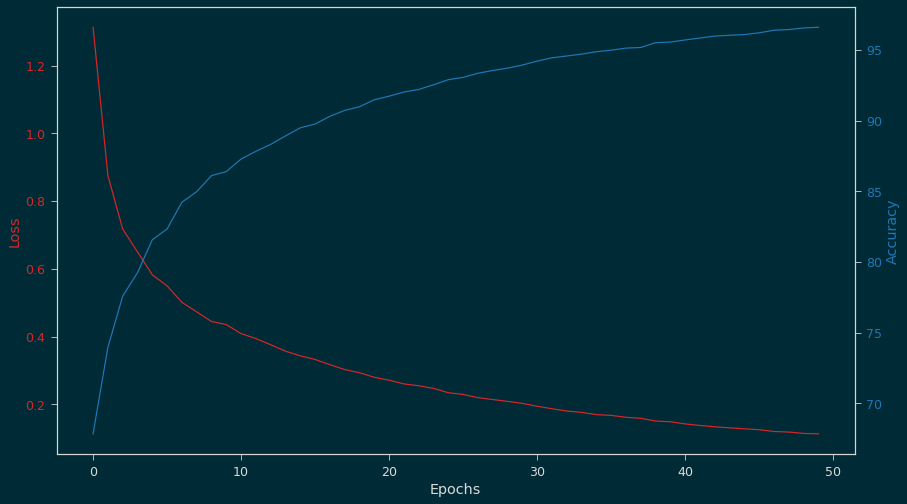

In [103]:
epoch_plot = np.arange(0, epoch_n)
fig, loss_plot = plt.subplots()

color = 'tab:red'
loss_plot.set_xlabel('Epochs')
loss_plot.set_ylabel('Loss', color=color)
loss_plot.plot(epoch_plot, mnist_loss, color=color)
loss_plot.tick_params(axis='y', labelcolor=color)

acc_plot = loss_plot.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
acc_plot.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
acc_plot.plot(epoch_plot, mnist_acc, color=color)
acc_plot.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

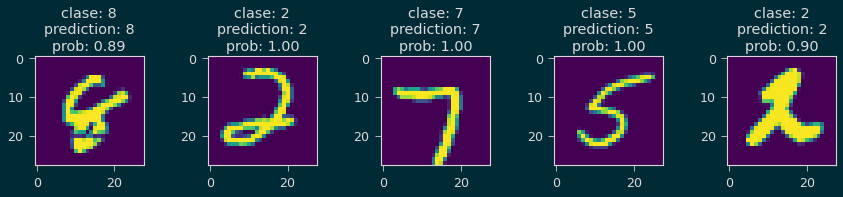

In [111]:
n_ejemplos = 5
fig, axs = subplots(ncols=n_ejemplos, figsize=(n_ejemplos*3, 2))

for i in range(n_ejemplos):  
  idx = randint(0,len(mnist_dataset))
  T, l = mnist_dataset[idx]
  img = T.view(28,28).numpy()
  pred_prob, pred_label = torch.max(mnist_model(T.to('cuda').view(1, 784)), dim=1)
  axs[i].set_title("clase: {}\nprediction: {}\nprob: {:.2f}".format(l, pred_label.item(), pred_prob.item()))
  axs[i].imshow(img)